In [1]:
import os
from collections.abc import Iterable
from datetime import datetime

import git
import networkx as nx

os.getcwd()

'/Users/timottinger/Projects/gitminer-jupyter/Notebooks'

In [2]:


def commits_in_period(repo_to_search: git.Repo, beginning: datetime, ending: datetime) -> Iterable[git.Commit]:
    for commit in repo_to_search.iter_commits():
        if beginning <= commit.committed_datetime <= ending:
            yield commit



In [3]:
class Locations:
    wfx_dir = "../../siemens-wfx"
    android_dir = "../../ClassDojo/dojo-android"
    ios_dir = "../../ClassDojo/dojo-behavior-ios"
    api_dir = "../../ClassDojo/api"


repo = git.Repo(Locations.ios_dir)
start_date = datetime(month=8, day=1, year=2024).astimezone()  #until_today - timedelta(days=90)
end_date = datetime(month=8, day=19, year=2024).astimezone()  #datetime.today().astimezone()


# Collect the child/parent edges
The idea is that each independent (unmerged) thread will not connect to any other 
threads. Since they are distinct, they will show up as being in different connected
groups than the other threads.

In [4]:
commit: git.Commit
graph = nx.Graph()
for commit in commits_in_period(repo, start_date, end_date):
    # Skip the merges, because they connect everything
    if len(commit.parents) > 1:
        continue
    for parent in commit.parents:
        print(commit.hexsha, parent.hexsha)
        graph.add_edge(commit.hexsha, parent.hexsha)

b3ae62450a1a8243c0f8404934b34051295f9e54 569ef0e53aebfb879bea330ba2181495f1b0eeb8
569ef0e53aebfb879bea330ba2181495f1b0eeb8 f1024c02919aa43c1fc78422131950add1e553e6
3f932190e370c42e2f1a5c586501f7b2eef2b136 5cab99fada147538c077a38ef8a6ee6e1ab11ef7
5cab99fada147538c077a38ef8a6ee6e1ab11ef7 e76c319aa54c1eb960343f4031706eaa6a751502
e76c319aa54c1eb960343f4031706eaa6a751502 b0086f51f34e89e521a3c7c48ebc21393063dd25
b0086f51f34e89e521a3c7c48ebc21393063dd25 bb9ee826a5d224e334db70111527bc4a9f00b54e
bb9ee826a5d224e334db70111527bc4a9f00b54e ef0fb9adc7d2fccb6b8511c294d90d3bd92dd3e4
ef0fb9adc7d2fccb6b8511c294d90d3bd92dd3e4 727e659c2154bae9dc6f3c189e3cc01c920a21f1
727e659c2154bae9dc6f3c189e3cc01c920a21f1 2762ac466fb238c2d1057474ef02015ff8703808
2762ac466fb238c2d1057474ef02015ff8703808 8bca385db1ea88e6fe4a12c2c5800faabfdeb810
8bca385db1ea88e6fe4a12c2c5800faabfdeb810 98964cc381512b4e252e442b1fd553592af35c66
f86a7de9326ee3741292c6bafefca1fd6ffff9f9 9409e4b4733895329069078b582cf103c451a26e
d8215a314cc4fbdb

In [5]:
connected = list(nx.connected_components(graph))


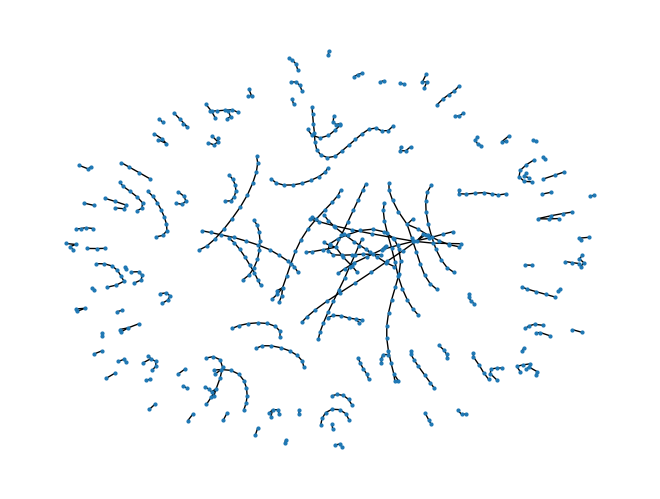

In [6]:
nx.draw(graph, with_labels=False, node_size=4)

In [7]:
with_merges = nx.Graph()
for commit in commits_in_period(repo, start_date, end_date):
    for parent in commit.parents:
        graph.add_edge(parent.hexsha, commit.hexsha)

still_unmerged = list(nx.connected_components(graph))

In [8]:

print(f"We identify {len(connected)} lines of work from {start_date.date()} through {end_date.date()}")
print(f"There seems to be {len(still_unmerged)} surviving line of work")

We identify 112 lines of work from 2024-08-01 through 2024-08-19
There seems to be 1 surviving line of work


# Going for a directed graph of all the nodes, can we spot where the split and join happen?


In [9]:
from collections import defaultdict

parents_of = defaultdict(list)
children_of = defaultdict(list)
commit_by_hexsha = dict()

for commit in repo.iter_commits():
    commit_by_hexsha[commit.hexsha] = commit
    for parent in commit.parents:
        parents_of[commit.hexsha].append(parent.hexsha)
        children_of[parent.hexsha].append(commit.hexsha)



In [10]:

for (key, value) in children_of.items():
    commit = commit_by_hexsha[key]
    if commit.committed_datetime < start_date:
        continue
    if len(value) != 1:
        print(key, commit.committed_datetime, commit.message)
        break

splits = [commit.hexsha for commit in repo.iter_commits() if len(children_of[commit.hexsha]) > 1]


f1024c02919aa43c1fc78422131950add1e553e6 2024-08-17 08:55:25-05:00 (T/P) Fix code login error handling and logging #fixed (#13382)


In [11]:
joins = [commit.hexsha for commit in repo.iter_commits() if len(parents_of[commit.hexsha]) > 1]



In [12]:
import pandas as pd

threads_df = pd.DataFrame(columns=["hexsha", "started", "ended"])


def trace_linear_history(commit):
    while True:
        message = commit.message
        author = commit.author
        when = commit.committed_datetime
        if commit.hexsha in splits or commit.hexsha in joins:
            return commit
        [commit] = commit.parents
    return commit


for hexsha in joins:
    joiner_commit = commit_by_hexsha[hexsha]
    joiner_message = joiner_commit.message
    for parent in joiner_commit.parents:
        if len(parent.parents) > 1:
            # assume nonlinear segments are roll-ups, rather 
            # than meaningful work: multiple parents with multiple parents
            # look like roll-ups.
            continue
        parent_message = parent.message
        start = trace_linear_history(parent)
        entry = dict(hexsha=hexsha, started=start.committed_datetime, ended=joiner_commit.committed_datetime)
        threads_df.add(entry)

threads_df



,hexsha,started,ended


In [13]:
import plotly.express as px

filtered_df = threads_df[threads_df['ended'] > '2024-01-01']
filtered_df

,hexsha,started,ended


In [ ]:

figure = px.timeline(filtered_df, x_start="started", x_end="ended")
figure.show()